## All Necassary Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torchvision

### Versions of all packages used in this notebook

In [2]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 1.7.1+cu110
Torchvision version: 0.8.2+cu110
CUDA is available: True


## Loading SAM model

In [3]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor # Import the SAM model, the SAM predictor and the SAM model registry

## Loading Neurons image

In [4]:
image = cv2.imread("neurons.jpg") 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert the image from BGR to RGB

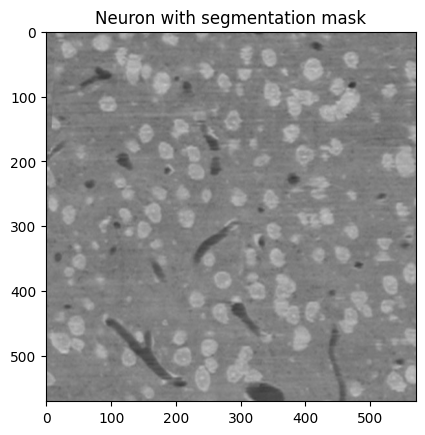

In [5]:
plt.title("Neuron with segmentation mask")
plt.imshow(image) # Show the image
plt.show()

## Writing checkpoints & type of Model

In [7]:
# writing model type & checkpoint name
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

In [8]:
device = "cuda" # Use the GPU if availableb

## Loading SAM model

In [9]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint) # Load the SAM model
sam.to(device=device) # Move the model to the GPU if available

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU()
        )
      )
      (1): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        

## Creating Mask Generator

In [10]:
mask_generator = SamAutomaticMaskGenerator(sam) # Create the mask generator

## Generating mask for the image of the neurons

In [13]:
masks = mask_generator.generate(image= image) # Generate the masks on the image, the masks are returned as a list of dictionaries

c:\Users\ahmed\anaconda3\envs\SAM_env\lib\site-packages\segment_anything\utils\amg.py:118: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  change_indices = diff.nonzero()


## Understanding masks type & length

In [14]:
print("Number of masks:", len(masks)) # Print the number of masks

Number of masks: 225


In [24]:
# print dict keys
masks[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 821,
 'bbox': [336, 78, 26, 38],
 'predicted_iou': 1.0051207542419434,
 'point_coords': [[347.953125, 115.984375]],
 'stability_score': 0.983132541179657,
 'crop_box': [0, 0, 571, 571]}

## Function to show annotations on the image

### Explanation of Show Annotations function:
The annotations are expected to be a list of dictionaries, where each dictionary represents an annotation with keys like 'area' and 'segmentation'.

The function begins by checking if the list of annotations is empty. If it is, the function returns immediately, doing nothing.

If the list is not empty, the function sorts the annotations in descending order based on their 'area' value. This is done using Python's built-in `sorted` function, with a lambda function as the key that extracts the 'area' value from each annotation.

The use of the lambda function with the key parameter of the sorted function allows you to customize the sorting order based on a specific key within each dictionary. In this case, it's sorting the list of dictionaries (anns) based on the values of the 'area' key in descending order.

Next, the function gets the current axes (plt.gca()) and turns off autoscaling. Autoscaling in matplotlib automatically adjusts the view limits of the plot to include all data points. Turning it off means the plot limits will remain constant even if new data is added.


The function then iterates over each annotation in the sorted list. For each annotation, it retrieves the 'segmentation' data, which is expected to be a 2D numpy array. It creates an image (img) of the same shape as the segmentation data, but with an additional dimension for color channels (RGB).

A random color mask is generated and applied to the image. This is done by creating a 1x3 array of random numbers (each between 0 and 1), converting it to a list, and taking the first (and only) element of the list. This results in a list of three random numbers, which serve as RGB values for the color mask. The color mask is applied to the image by setting each color channel of the image to the corresponding value in the color mask.

Finally, the function displays the image on the current axes, with the segmentation data used as the alpha channel to create a transparency effect. The alpha channel is created by multiplying the segmentation data by 0.35, which means the segmentation areas will be 35% opaque. The `np.dstack` function is used to stack the image and alpha channel along the third dimension, creating a 3D array that can be displayed as an RGBA image.

In [28]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

## Segmented vs Non-Segmented images

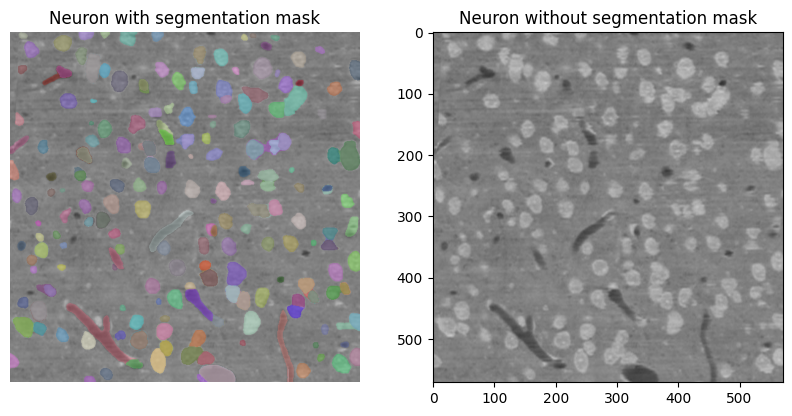

In [33]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("Neuron with segmentation mask")
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.subplot(2,2,2)
plt.title("Neuron without segmentation mask")
plt.imshow(image)
plt.show() 

In [35]:
img_house = cv2.imread("houses.jpg")
img_house = cv2.cvtColor(img_house, cv2.COLOR_BGR2RGB)

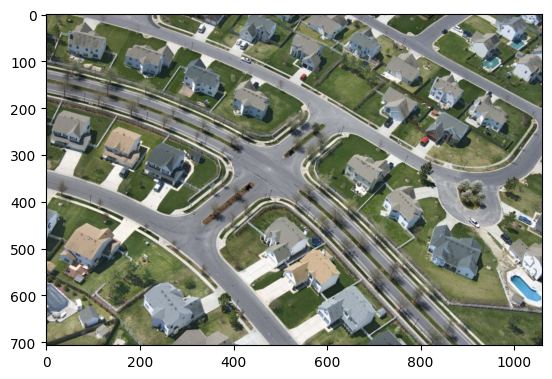

In [37]:
plt.imshow(img_house)
plt.show()

In [38]:
masks_house = mask_generator.generate(image= img_house) # Generate the masks on the image, the masks are returned as a list of dictionaries

In [39]:
print("Number of masks:", len(masks_house)) # Print the number of masks

Number of masks: 264


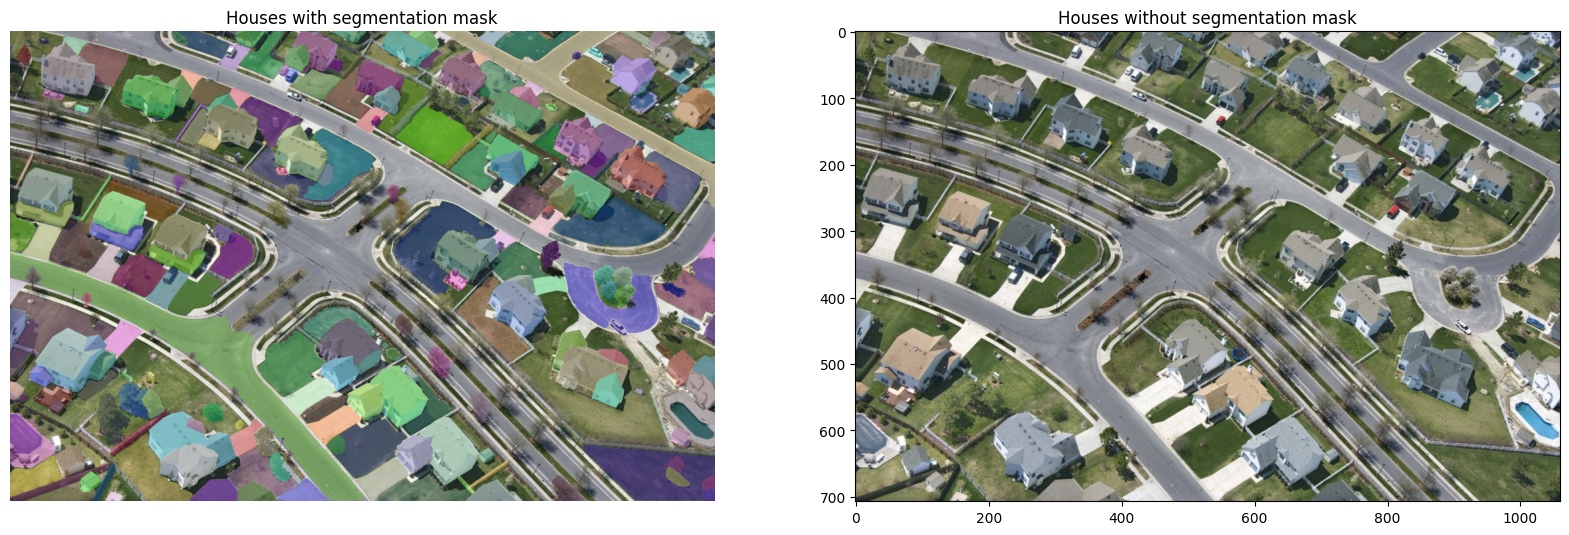

In [41]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.title("Houses with segmentation mask")
plt.imshow(img_house)
show_anns(masks_house)
plt.axis('off')
plt.subplot(2,2,2)
plt.title("Houses without segmentation mask")
plt.imshow(img_house)
plt.show()